# The Long-form Legal Question Answering (LLeQA) dataset


In [7]:
import os
import textwrap
import itertools
import datetime as dt
from functools import wraps
from typing import List, Dict, Tuple, Union, Callable, Any, Optional

import math
import nltk
import spacy
import numpy as np
import pandas as pd
#nltk.download('stopwords')

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from wordcloud import WordCloud
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

# Plotly theme and colors.
THEME = "plotly_dark"
WIDTH = 1500
HEIGHT = 900
SNS_PALETTE = sns.color_palette().as_hex()[:6][::-1]
MY_PALETTE = ["#23aaff", "#ff6555", "#66c56c", "#f4b247"]
MY_PALETTE_2 = ["#629ABE", "#BF3838", "#62AA6F", "#B4B3CF", "#7567A0"]
px.defaults.color_discrete_sequence = MY_PALETTE_2


STOPWORDS = set(nltk.corpus.stopwords.words('french')) | spacy.load("fr_core_news_md").Defaults.stop_words
EN_CATEGORY = {
    "Argent": "Money",
    "Etrangers": "Immigration",
    "Famille": "Family",
    "Justice": "Justice",
    "Logement": "Housing",
    "Protection sociale": "Healthcare",
    "Travail": "Work",
    "Vie privée": "Privacy"
}
EN_SUBCATEGORY = {
    "Aidants proches": "Close caregivers",
    "Aide du CPAS": "Assistance from CPAS",
    "Aide pour gérer le budget": "Help with budget management",
    "Allocations familiales et de naissance": "Family and childbirth allowances",
    "Assurances": "Insurance",
    "Au tribunal": "In court",
    "Casier judiciaire": "Criminal record",
    "Chômage": "Unemployment",
    "Contester une décision de sécurité sociale": "Challenging a social security decision",
    "Dettes": "Debts",
    "Domicile": "Home",
    "Droits du patient": "Patient rights",
    "Décès": "Death",
    "Détenus et ex-détenus": "Prisoners and ex-prisoners",
    "Etrangers et aides du CPAS": "Foreigners and CPAS assistance",
    "Etrangers et famille": "Foreigners and family",
    "Etrangers et soins de santé": "Foreigners and healthcare",
    "Etrangers et travail salarié": "Foreigners and salaried work",
    "Expulsion": "Expulsion",
    "Grossesse et naissance": "Pregnancy and childbirth",
    "Handicap": "Disability",
    "Hébergement": "Accommodation",
    "Impôts": "Taxes",
    "Insalubrité en Wallonie": "Unsanitary conditions in Wallonia",
    "L'avocat": "The lawyer",
    "Les conséquences de la colocation sur les allocations sociales": "The consequences of cohabitation on social benefits",
    "Lien parents/enfants": "Parent/child relationship",
    "Location en Wallonie": "Renting in Wallonia",
    "Location à Bruxelles": "Renting in Brussels",
    "Maladie - incapacité de travail": "Illness - incapacity to work",
    "Mesures de protection des personnes": "Measures to protect individuals",
    "Mineurs étrangers": "Foreign minors",
    "Nationalité belge": "Belgian nationality",
    "Obligations alimentaires": "Child support",
    "Pensions et Grapa": "Pensions and Grapa",
    "Protection du consommateur": "Consumer protection",
    "Protection internationale (avant appelée asile)": "International protection (formerly called asylum)",
    "Respect de la vie privée": "Respect for privacy",
    "Régler un conflit familial": "Resolving a family conflict",
    "Santé et maladie": "Health and illness",
    "Secret professionnel": "Professional secrecy",
    "Situation de couples": "Couples' situation",
    "Séjour européen": "European stay",
    "Séjour illégal": "Illegal stay",
    "Séjour non-européen": "Non-European stay",
    "Titres de séjour": "Residence permits",
    "Travail et parentalité": "Work and parenthood",
    "Travail salarié": "Salaried work",
    "Urbanisme": "Urban planning",
    "Voisinage": "Neighborhood",
}
EN_CODES = {
    "Arrêté du collège réuni de la commission communautaire commune du 28 janvier 2021 portant exécution de l'ordonnance du 10 décembre 2020 relative à l'allocation pour l'aide aux personnes âgées": "Ordinance of December 10, 2020 on the allowance for assistance to the elderly",
    "Arrêté ministériel du 26 novembre 1991 portant les modalités d'application de la réglementation du chômage": "Ministerial decree of November 26, 1991 on the implementation modalities of the unemployment regulations",
    "Arrêté royal de 16 juillet 1992 relatif aux registres de la population et au registre des étrangers": "Royal decree of July 16, 1992 on the population and the foreigners' register",
    "Arrêté royal du 20 juillet 1971 instituant une assurance indemnités et une assurance maternité en faveur des travailleurs indépendants et des conjoints aidants": "Royal decree of July 20, 1971 on the allowance insurance and maternity insurance for self-employed workers and assisting spouses",
    "Arrêté royal du 21 décembre 1967 portant règlement général du régime de pension de retraite et de survie des travailleurs salariés": "Royal decree of December 21, 1967 on the general regulations of the retirement and survival pension scheme for salaried workers",
    "Arrêté royal du 23 décembre 1996 portant exécution des articles 15, 16 et 17 de la loi du 26 juillet 1996 portant modernisation de la sécurité sociale et assurant la viabilité des régimes légaux des pensions": "Royal decree of December 23, 1996 on the modernization of social security and ensuring the viability of the legal pension schemes",
    "Arrêté royal du 23 mai 2001 portant règlement général en matière de garantie de revenus aux personnes âgées": "Royal decree of May 23, 2001 on the general regulations concerning income guarantees for elderly persons",
    "Arrêté royal du 25 novembre 1991 portant réglementation du chômage": "Royal decree of November 25, 1991 on regulating unemployment",
    "Arrêté royal du 3 juillet 1996 portant exécution de la loi relative à l'assurance obligatoire soins de santé et indemnités, coordonnée le 14 juillet 1994": "Royal decree of July 3, 1996 on the law on mandatory health care and benefits insurance",
    "Arrêté royal du 30 mars 1967 déterminant les modalités générales d'exécution des lois relatives aux vacances annuelles des travailleurs salariés": "Royal decree of March 30, 1967 on the general implementation modalities of laws concerning the annual leave of salaried workers",
    "Arrêté royal du 6 juillet 1987 relatif à l'allocation de remplacement de revenus et à l'allocation d'intégration": "Royal decree of July 6, 1987 on the replacement income allowance and integration allowance",
    "Arrêté royal du 8 octobre 1981 sur l'accès au territoire, le séjour, l'établissement et l'éloignement des étrangers": "Royal decree of October 8, 1981 on access to the territory, residence, establishment, and removal of foreigners",
    "Arrêté royal du 9 mai 1984 pris en exécution de l'article 100bis, § 1er, de la loi du 8 juillet 1976 organique des centres publics d'aide sociale": "Royal decree of May 9, 1984 on public social welfare centers",
    "Arrêté royal n° 50 du 24 octobre 1967 relatif à la pension de retraite et de survie des travailleurs salariés": "Royal decree of October 24, 1967 on the retirement and survival pension of salaried workers",
    "Code bruxellois de l'air, du climat et de la maîtrise de l'énergie": "Brussels Code on Air, Climate, and Energy Management",
    "Code bruxellois de l'aménagement du territoire": "Brussels Code on Urban Planning",
    "Code bruxellois du logement": "Brussels Housing Code",
    "Code civil": "Civil Code",
    "Code consulaire": "Consular Code",
    "Code d'instruction criminelle": "Code of Criminal Procedure",
    "Code de droit international privé": "Code of Private International Law",
    "Code de droit économique": "Code of Economic Law",
    "Code de la démocratie locale et de la décentralisation": "Code of Local Democracy and Decentralization",
    "Code de la fonction publique wallonne": "Code of the Walloon Civil Service",
    "Code de la nationalité belge": "Code of Belgian Nationality",
    "Code de la navigation": "Code of Navigation",
    "Code des droits et taxes divers": "Code of Miscellaneous Rights and Taxes",
    "Code des sociétés et des associations": "Code of Companies and Associations",
    "Code du bien-être au travail": "Code of Well-being at Work",
    "Code ferroviaire": "Railway Code",
    "Code forestier": "Forest Code",
    "Code judiciaire": "Judicial Code",
    "Code pénal": "Penal Code",
    "Code pénal militaire": "Military Penal Code",
    "Code pénal social": "Social Penal Code",
    "Code rural": "Rural Code",
    "Code réglementaire wallon de l'action sociale et de la santé": "Walloon Regulatory Code on Social Welfare and Health",
    "Code wallon de l'action sociale et de la santé": "Walloon Code on Social Welfare and Health",
    "Code wallon de l'agriculture": "Walloon Code of Agriculture",
    "Code wallon de l'eau": "Walloon Code of Water",
    "Code wallon de l'enseignement fondamental et de l'enseignement secondaire": "Walloon Code of Primary and Secondary Education",
    "Code wallon de l'environnement": "Walloon Code of the Environment",
    "Code wallon de l'habitation durable": "Walloon Code of Sustainable Housing",
    "Code wallon du bien-être des animaux": "Walloon Code of Animal Welfare",
    "Code wallon du développement terrritorial": "Walloon Code of Territorial Development",
    "Code wallon du tourisme": "Walloon Code of Tourism",
    "Code électoral": "Electoral Code",
    "Code électoral communal bruxellois": "Brussels Municipal Electoral Code",
    "Constitution": "Constitution",
    "Décret de la région wallonne du 8 février 2018 relatif à la gestion et au paiement des prestations familiales": "Decree of the Walloon Region of February 8, 2018, regarding the management and payment of family benefits",
    "Décret du 15 mars 2018 relatif au bail d'habitation": "Decree of March 15, 2018, regarding residential leases",
    "Loi du 10 avril 1971 sur les accidents du travail": "Law of April 10, 1971, on occupational accidents",
    "Loi du 11 avril 1995 visant à instituer 'la charte' de l'assuré social": "Law of April 11, 1995, aiming to establish the 'charter' of the social insured",
    "Loi du 15 décembre 1980 sur l'accès au territoire, le séjour, l'établissement et l'éloignement des étrangers": "Law of December 15, 1980, on access to the territory, residence, establishment, and removal of foreigners",
    "Loi du 16 mars 1971 sur le travail": "Law of March 16, 1971, on labor",
    "Loi du 19 juillet 1991 relative aux registres de la population, aux cartes d'identité, aux cartes d'étranger et aux documents de séjour": "Law of July 19, 1991, on population registers, identity cards, foreigner cards, and residence documents",
    "Loi du 2 avril 1965 relative à la prise en charge des secours accordés par les centres publics d'aide sociale": "Law of April 2, 1965, concerning the support of aid provided by public social welfare centers",
    "Loi du 22 août 2002 relative aux droits du patient": "Law of August 22, 2002, regarding patient rights",
    "Loi du 22 mars 2001 instituant la garantie de revenus aux personnes âgées": "Law of March 22, 2001, establishing income guarantees for elderly persons",
    "Loi du 26 juin 1990 relative à la protection des malades mentaux": "Law of June 26, 1990, on the protection of mentally ill patients",
    "Loi du 26 mai 2002 concernant le droit à l'intégration sociale": "Law of May 26, 2002, concerning the right to social integration",
    "Loi du 27 février 1987 relative aux allocations aux personnes handicapées": "Law of February 27, 1987, concerning allowances for disabled persons",
    "Loi du 3 juillet 1978 relative aux contrats de travail": "Law of July 3, 1978, on employment contracts",
    "Loi du 4 avril 2014 relative aux assurances": "Law of April 4, 2014, concerning insurance",
    "Loi générale relative aux allocations familiales (lgaf) du 19 décembre 1939": "General Law on Family Allowances (LGAF) of December 19, 1939",
    "Loi relative à l'assurance obligatoire soins de santé et indemnités, coordonnée le 14 juillet 1994": "Law on mandatory health care and benefits insurance, coordinated on July 14, 1994",
    "Ordonnance du 10 décembre 2020 relative à l'allocation pour l'aide aux personnes âgées": "Ordinance of December 10, 2020, regarding the allowance for assistance to the elderly",
    "Ordonnance du 25 avril 2019 réglant l'octroi des prestations familiales": "Ordinance of April 25, 2019, regulating the granting of family benefits",
}

def start_pipeline(dataf):
    return dataf.copy()

def translate_to_en(dataf, column, translations):
    dataf[column] = dataf[column].map(translations)
    return dataf

def break_text(datas, width):
    return datas.apply(lambda x: "<br>".join(textwrap.wrap(str(x), width=width)))

def create_subplots_grid(figures, titles=None, ncols=2, col_widths=[0.5,0.5]):
    # Make sure col_widths values are correct.
    assert len(col_widths) == ncols, 'Number of column widths must be equal to number of columns'
    assert sum(col_widths) == 1.0, 'Sum of column widths must be equal to 1.0'

    # Initialize figure with subplots.
    nrows=int(np.ceil(len(figures)/ncols))
    fig = make_subplots(cols=ncols, rows=nrows,
                        column_widths=col_widths, row_heights=None,
                        shared_xaxes=False, shared_yaxes=False,
                        vertical_spacing=0.1, horizontal_spacing=0.2,
                        specs=np.array([{'type': sub['data'][0]['type']} for sub in figures] 
                                        + ([None]* ((ncols*nrows)-len(figures))))
                                .reshape((nrows,ncols))
                                .tolist(),
                        subplot_titles=titles)
    
    # Add traces.
    for i, subfig in enumerate(figures):
        idx = i+1 if i%ncols==0 else i
        fig.add_trace(subfig['data'][0], row=int(np.ceil(idx/ncols)), col=i%ncols+1)
        fig.update_xaxes(title_text=subfig['layout']['xaxis']['title']['text'], row=int(np.ceil(idx/ncols)), col=i%ncols+1)
        fig.update_yaxes(title_text=subfig['layout']['yaxis']['title']['text'], row=int(np.ceil(idx/ncols)), col=i%ncols+1)
    
    # Update general layout.
    fig.update_layout(width=1600, height=770*nrows, title_text="", template=THEME)
    return fig

def save_plotly_figure_for_paper(fig, filename, width=WIDTH, height=HEIGHT, margin=dict(r=10, l=10, b=10, t=10)):
    os.makedirs('./images', exist_ok=True)
    (fig.update_layout(template='simple_white',
                       width=width, height=height, margin=margin,
                       #legend=dict(x=0.9, y=0.99, bordercolor="#d3d3d3", borderwidth=0),
                       font=dict(family="Times New Roman, Times, serif", size=16, color="black")) #Helvetica, 
        .update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=False)
        .update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=False)
        .write_image("./images/"+filename+".pdf", format="pdf")
    )

def save_seaborn_figure_for_paper(
        plot, filename: str, 
        xlabel: str, ylabel: str, 
        xlim: Tuple[int, int], xtick_step: int,
        ylim: Tuple[int, int], ytick_step: int,
    ):
    sns.set(font="Times New Roman", font_scale=1.2, style="ticks", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":16})
    plot.set_xlabel(xlabel, labelpad=15)
    plot.set_ylabel(ylabel, labelpad=15)
    plot.set_xlim(*xlim)
    plot.set_ylim(*ylim)
    plot.set_xticks(range(xlim[0], xlim[1] + 1, xtick_step))
    plot.set_yticks(range(ylim[0], ylim[1] + 1, ytick_step))
    for line in plot.get_lines():
        line.set_clip_on(False)
    legend_labels, _= plot.get_legend_handles_labels()
    plot.legend(legend_labels, ['' + i for i in _[:]], title=None, loc="upper center", bbox_to_anchor=(.5, 1.22), ncol=3, frameon=False)
    sns.despine(offset={'bottom':10, 'left':10})
    plt.savefig(f"./images/{filename}.pdf", format='pdf', bbox_inches='tight')
    return


dfA = pd.read_json('../data/lleqa/articles.json', orient='records')
dfQ_train = pd.read_json('../data/lleqa/questions_train.json', orient='records')
dfQ_dev = pd.read_json('../data/lleqa/questions_dev.json', orient='records')
dfQ_test = pd.read_json('../data/lleqa/questions_test.json', orient='records')
dfQ = pd.concat([dfQ_train, dfQ_dev, dfQ_test])

# Basics Statistics

In [8]:
#--------------------------------------------#
#               DATASET SIZE                 
#--------------------------------------------#
print("\n", "#", "-"*40, "#", "\n", "# DATASET SIZE", "\n", "#", "-"*40, "#", sep="")
print("Number of articles:", len(dfA))
print("Number of questions:", len(dfQ))
print("Number of train questions:", len(dfQ_train), "(", round((len(dfQ_train)/len(dfQ))*100, 1), "%)")
print("Number of dev questions:", len(dfQ_dev), "(", round((len(dfQ_dev)/len(dfQ))*100, 1), "%)")
print("Number of test questions:", len(dfQ_test), "(", round((len(dfQ_test)/len(dfQ))*100, 1), "%)")

#--------------------------------------------#
#               STATUTES                 
#--------------------------------------------#
print("\n", "#", "-"*40, "#", "\n", "# STATUTES", "\n", "#", "-"*40, "#", sep="")
print("Number of articles that comes from a 'Code':", len(dfA[dfA['code'].str.startswith('Code')]))
print("Number of articles that do not come from a 'Code':", len(dfA[~dfA['code'].str.startswith('Code')]))

#--------------------------------------------#
#               WORD COUNTS                 
#--------------------------------------------#
print("\n", "#", "-"*40, "#", "\n", "# WORD COUNTS", "\n", "#", "-"*40, "#", sep="")
print("Questions:\n", dfQ['question'].apply(lambda x: len(x.split())).describe(), "\n")
print("Answers:\n", dfQ['answer'].apply(lambda x: len(x.split())).describe(), "\n")

dfA['num_words'] = dfA['article'].apply(lambda x: len(x.split()))
print("Articles (all):\n", dfA['num_words'].describe(), "\n")

article_ids = dfQ['article_ids'].explode().unique().tolist()
print("Articles (referenced only):\n", dfA[dfA['id'].isin(article_ids)]['num_words'].describe(), "\n")

print("Number of articles that are longer than 500 words:", len(dfA[dfA['num_words'] > 500]))

dfQ['evidence'] = dfQ['article_ids'].apply(lambda x: "\n\n".join(dfA[dfA['id'].isin(x)]['article'].tolist()))
dfQ['evidence_num_words'] = dfQ['evidence'].apply(lambda x: len(x.split()))
print("Evidence (all relevant articles to a question):\n", dfQ['evidence_num_words'].describe(), "\n")

#--------------------------------------------#
#               TOPIC DISTRIBUTION                 
#--------------------------------------------#
print("\n", "#", "-"*40, "#", "\n", "# TOPIC DISTRIBUTION", "\n", "#", "-"*40, "#", sep="")

def create_category_and_subcategory_columns(dfQ):
    dfQ[['category', 'subcategory', 'topics']] = dfQ['topics'].str[0].str.split(',', n=2, expand=True)
    return dfQ

def get_questions_distribution(dfQ, norm=False):
    return dfQ['category'].value_counts(normalize=norm).round(3)

train_distribution = (dfQ_train
    .pipe(start_pipeline)
    .pipe(create_category_and_subcategory_columns)
    .pipe(get_questions_distribution)
)
dev_distribution = (dfQ_dev
    .pipe(start_pipeline)
    .pipe(create_category_and_subcategory_columns)
    .pipe(get_questions_distribution)
)
test_distribution = (dfQ_test
    .pipe(start_pipeline)
    .pipe(create_category_and_subcategory_columns)
    .pipe(get_questions_distribution)
)
all_distribution = (dfQ
    .pipe(start_pipeline)
    .pipe(create_category_and_subcategory_columns)
    .pipe(get_questions_distribution, norm=True)
)
print("Train:\n", train_distribution, "\n")
print("Dev:\n", dev_distribution, "\n")
print("Test:\n", test_distribution, "\n")
print("All:\n", all_distribution, "\n")


#----------------------------------------#
# DATASET SIZE
#----------------------------------------#
Number of articles: 27942
Number of questions: 1868
Number of train questions: 1472 ( 78.8 %)
Number of dev questions: 201 ( 10.8 %)
Number of test questions: 195 ( 10.4 %)

#----------------------------------------#
# STATUTES
#----------------------------------------#
Number of articles that comes from a 'Code': 23759
Number of articles that do not come from a 'Code': 4183

#----------------------------------------#
# WORD COUNTS
#----------------------------------------#
Questions:
 count    1868.000000
mean       15.032120
std         5.559922
min         4.000000
25%        11.000000
50%        14.000000
75%        18.000000
max        44.000000
Name: question, dtype: float64 

Answers:
 count    1868.000000
mean      263.601713
std       126.179487
min        12.000000
25%       172.000000
50%       241.000000
75%       334.000000
max      1232.000000
Name: answer, dtype: float64

# 1. What are the questions about?

In [9]:
def create_category_columns(dataf):
    dataf[['category', 'subcategory', 'subsubcategories']] = dataf['topics'].str[0].str.split(',', n=2, expand=True)
    dataf[['category', 'subcategory', 'subsubcategories']] = dataf[['category', 'subcategory', 'subsubcategories']].apply(lambda x: x.str.strip())
    return dataf

def plot_categories_as_sunburst(dataf):
    dataf['tmp'] = " "
    dataf = dataf.fillna('-')
    return (
        px.sunburst(
            dataf,
            path=['tmp', 'category', 'subcategory'],
            labels={'count':'Questions'},
            color_discrete_sequence=px.colors.qualitative.Pastel,
            width=WIDTH, height=HEIGHT,
            template=THEME
        )
        .update_traces(
            textinfo="label+percent root", 
            insidetextorientation='radial',
            hovertemplate="<br>".join([
                "<b>%{label}</b>",
                "Questions: %{value}",
                "Root ratio: %{percentRoot:%.3Òf}",
                "Parent ratio: %{percentParent:%.3f}",
            ])
        )
        .update_layout(uniformtext=dict(minsize=30, mode=False))
    )

def plot_categories_as_treemap(dataf):
    dataf = dataf.fillna('-')
    return (
        px.treemap(
            dataf,
            path=['category', 'subcategory'],# 'topic'],
            labels={'count':'Questions'},
            color_discrete_sequence=px.colors.qualitative.Pastel,
            width=WIDTH, height=HEIGHT,
            template=THEME,
        )
        .update_traces(
            textinfo="label+percent root",
            hovertemplate="<br>".join([
                "<b>%{label}</b>",
                "Questions: %{value}",
                "Root ratio: %{percentRoot:%.2f}",
                "Parent ratio: %{percentParent:%.2f}",
            ])
        )
    )

def count_categories(dataf):
    count_df = (dataf
        .groupby('category')
        .size()
        .reset_index(name="count")
        .sort_values(by='count', ascending=False)
    )
    total = count_df['count'].sum()
    count_df['percentage'] = (count_df['count'] / total) * 100
    return count_df

def plot_category_counts(dataf, show_ratio=False):
    dataf['count_text'] = dataf.apply(lambda row: f"{row['count']} ({row['percentage']:.2f}%)", axis=1) if show_ratio else dataf['count']
    return (
        px.bar(
            dataf,
            x='category', y='count', text='count_text',
            labels={'category':'Category', 'count':'Number of questions'},
            width=WIDTH, height=HEIGHT,
            template=THEME,
        )
        .update_traces(textposition='outside')
    )

In [10]:
fig = (dfQ
    .pipe(start_pipeline)
    .pipe(create_category_columns)
    .pipe(translate_to_en, 'category', EN_CATEGORY)
    .pipe(translate_to_en, 'subcategory', EN_SUBCATEGORY)
    .pipe(plot_categories_as_sunburst)
)
save_plotly_figure_for_paper(go.Figure(fig), 'category_sunburst')
fig.show()

In [11]:
fig = (dfQ
    .pipe(start_pipeline)
    .pipe(create_category_columns)
    .pipe(translate_to_en, 'category', EN_CATEGORY)
    .pipe(translate_to_en, 'subcategory', EN_SUBCATEGORY)
    .pipe(plot_categories_as_treemap)
)
save_plotly_figure_for_paper(go.Figure(fig), 'category_treemap')
fig.show()

In [12]:
fig = (dfQ
        .pipe(start_pipeline)
        .pipe(create_category_columns)
        .pipe(translate_to_en, 'category', EN_CATEGORY)
        .pipe(count_categories)
        .pipe(plot_category_counts)
)
save_plotly_figure_for_paper(go.Figure(fig), 'category_barplot', width=700, height=500)
fig.show()

|    | category    |   count |   percentage |
|---:|:------------|--------:|-------------:|
|  2 | Housing     |     519 |     27.7837  |
|  1 | Healthcare  |     393 |     21.0385  |
|  0 | Family      |     255 |     13.651   |
|  7 | Work        |     202 |     10.8137  |
|  3 | Immigration |     181 |      9.68951 |
|  5 | Money       |     141 |      7.54818 |
|  6 | Privacy     |     104 |      5.56745 |
|  4 | Justice     |      73 |      3.90792 |


# 2. How many references do questions have?

In [13]:
def add_nitems_feature(dataf, column):
    return dataf.assign(nitems=lambda d: d[column].apply(len))

def filter_nitems(dataf, nitems):
    return dataf.loc[tmp['nitems'] <= nitems]

def plot_nrefs_barplot(dataf):
    dataf['count'] = 1
    dataf['question'] = break_text(dataf['question'], width=50)
    #dataf['references'] = break_text(dataf['references'], width=50)
    dataf['article_ids'] = break_text(dataf['article_ids'], width=50)
    return (
        px.bar(
            dataf,
            x="nitems", y="count",
            labels={'nitems':'Reference(s)/question', 'count':'Questions count'},
            custom_data=['id','question','article_ids'],#'references'
            width=WIDTH, height=HEIGHT,
            template=THEME,
        )
        .update_traces(
            opacity=0.8,
            hovertemplate="<br>".join([
                #"ColX: %{x}", "ColY: %{y}",
                "<b>Question ID</b>: %{customdata[0]}",
                "<b>Question</b>: %{customdata[1]}",
                #"<b>Reference(s)</b>: %{customdata[2]}",
                "<b>Reference ID(s)</b>: %{customdata[2]}",
            ]),
            marker_color='rgb(158,202,225)', 
            marker_line_color='rgb(8,48,107)', 
            marker_line_width=1.5,
        )
        .update_xaxes(nticks=20, ticks="outside")
    )

def plot_nrefs_piechart(dataf, maxdisplay=10):
    dataf = (dataf
        .groupby("nitems", as_index=False)
        .agg(count=("id", "count"))
    )
    dataf = pd.concat([
        dataf[dataf['nitems'] <= maxdisplay], 
        pd.DataFrame({'nitems':[str(maxdisplay)+'+'], 'count':[dataf.loc[dataf['nitems'] > maxdisplay, "count"].sum()]})
    ])
    return (px.pie(dataf, 
        values='count', names='nitems', 
        labels={'nitems':'Reference(s)/question', 'count':'Questions'},
        width=WIDTH, height=HEIGHT,
        template=THEME,
    ))

def plot_violinbox(dataf, column_name, ylabel, show_id=False):
    fig = (px.violin(dataf,
        y=column_name,
        box=True, points="outliers", hover_data=['id'] if show_id else None,
        labels={column_name:ylabel, 'id': 'ID'} if show_id else {column_name:ylabel},
        #color_discrete_sequence=px.colors.qualitative.G10,
        width=WIDTH, height=HEIGHT,
        template=THEME,
    ))
    for y in zip(["Median","Max"], dataf[column_name].quantile([0.5,1])):
        fig.add_annotation(y=y[1], x=0.5, text=y[0] + ":" + str(int(y[1])), showarrow=False, font=dict(size=16))
    return fig

In [14]:
create_subplots_grid(
    figures=[
        dfQ
            .pipe(start_pipeline)
            .pipe(add_nitems_feature, 'article_ids')
            .pipe(plot_nrefs_barplot),
        dfQ
            .pipe(start_pipeline)
            .pipe(add_nitems_feature, 'article_ids')
            .pipe(plot_nrefs_piechart, maxdisplay=5)
    ],
    ncols=2, col_widths=[0.7,0.3],
)

In [42]:
fig = (dfQ
    .pipe(start_pipeline)
    .pipe(add_nitems_feature, 'article_ids')
    #.pipe(filter_nitems, 85)
    .pipe(plot_violinbox, 'nitems', 'Number of articles', show_id=True)
)
save_plotly_figure_for_paper(go.Figure(fig), 'articles_per_question', width=300, height=400)
fig.show()

# 3. How many articles are there in the retrieval corpus?

In [16]:
def add_isref_feature(dataf, reference_ids):
    dataf['isref'] = dataf['id'].apply(lambda x: 'Referenced' if x in reference_ids else 'Unreferenced')
    return dataf

def count_articles_by_code(dataf):
    return (dataf
        .groupby(by=["code", "isref"], as_index=False)
        .agg(count=("id", "count"))
        .sort_values('count', ascending=False)
    )

def plot_articles_as_barchart(dataf):
    return (
        px.bar(
            dataf,
            x="code", y="count", color="isref",
            labels={'code':'', 'count':'Number of articles', 'isref': 'Is a reference'},
            color_discrete_map={"Unreferenced": MY_PALETTE_2[-1], "Referenced": MY_PALETTE_2[-2]},
            template=THEME, width=WIDTH, height=HEIGHT,
        )
        .update_yaxes(range=[0, 3000])
        .update_traces(texttemplate='%{y}', textposition='inside')
        .update_layout(
            legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="center", x=0.5, font=dict(size=25)), legend_title_text='',
            xaxis=dict(tickangle=25),
            yaxis=dict(title_font=dict(size=25)),
        )
    )

In [55]:
fig = (dfA
    .pipe(start_pipeline)
    .pipe(add_isref_feature, set(itertools.chain.from_iterable(dfQ['article_ids'])))
    .pipe(count_articles_by_code)
    .pipe(translate_to_en, 'code', EN_CODES)
    .pipe(plot_articles_as_barchart)
)
save_plotly_figure_for_paper(go.Figure(fig), 'barplot_statutes', width=3200, height=1600)
fig.show()

# 4. How long are the questions and articles?

In [18]:
def add_length_feature(dataf, column_name):
    return dataf.assign(length=lambda d: d[column_name].str.split().str.len())

def analyze_article(dataf, article_id):
    print("- Reference: Art. {} du {}\n  {}".format(dataf.loc[dataf['id'] == article_id, 'article_no'].values[0], dataf.loc[dataf['id'] == article_id, 'code'].values[0], "-"*10))
    print("- About: {}\n  {}".format(dataf.loc[dataf['id'] == article_id, 'description'].values[0], "-"*6))
    print("- Char count: {}\n  {}".format(len(dataf.loc[dataf['id'] == article_id, 'article'].values[0]), "-"*11))
    print("- Word count: {}\n  {}".format(len(dataf.loc[dataf['id'] == article_id, 'article'].values[0].split()), "-"*11))
    print("- Article:\n  {}\n{}".format("-"*8, dataf.loc[dataf['id'] == article_id, 'article'].values[0]))

In [19]:
fig=(dfA
    .pipe(start_pipeline)
    .pipe(add_length_feature, 'article')
    .pipe(plot_violinbox, 'length', 'Number of words', show_id=True)
)
save_plotly_figure_for_paper(go.Figure(fig), 'words_per_article', width=300, height=400)
fig.show()

In [20]:
fig=(dfQ
    .pipe(start_pipeline)
    .pipe(add_length_feature, 'question')
    .pipe(plot_violinbox, 'length', 'Number of words', show_id=True)
)
save_plotly_figure_for_paper(go.Figure(fig), 'words_per_question', width=300, height=400)
fig.show()

In [21]:
analyze_article(dfA, 27838)

- Reference: Art. 191 du Loi relative à l'assurance obligatoire soins de santé et indemnités, coordonnée le 14 juillet 1994
  ----------
- About: Du financement, Des ressources de l'assurance et de leur répartition, Des ressources de l'assurance
  ------
- Char count: 128904
  -----------
- Word count: 20244
  -----------
- Article:
  --------
Les ressources de l'assurance sont constituées par :1° une quote-part des moyens financiers de la gestion globale déterminée conformément à l'article 24, § 1er, 1erbis, 1erter et 1erquater, de la loi du 29 juin 1981 établissant les principes généraux de la sécurité sociale des travailleurs salariés;1°bis une quote-part de la répartition annuelle des ressources visées aux articles 6 et 7 de l'arrêté royal du 18 novembre 1996 visant l'introduction d'une gestion financière globale dans le statut social des travailleurs indépendants, en application du chapitre 1er du Titre VI de la loi du 26 juillet 1996 portant modernisation de la sécurité sociale e

# 5. What are the most frequent words in the articles?

In [22]:
def create_wordcloud(texts):
    return (WordCloud(width=4000, height=2000,
                      random_state=42, collocations=False, 
                      background_color='black', colormap='Set1', 
                      stopwords=STOPWORDS)
                .generate(' '.join(texts)))

def plot_wordclouds(dataf, text_col, split_col, theme='white', ncols=2):
    colors = {'black':{'background':'black', 'title':'white'}, 
              'white':{'background':'white', 'title':'black'}}
    
    split_on_values = dataf[split_col].unique()
    nrows=int(np.ceil(len(split_on_values)/ncols))

    fig, axarr = plt.subplots(ncols=ncols, nrows=nrows, figsize=(40,30))
    fig.patch.set_facecolor(colors[theme]['background'])

    for i, code in enumerate(split_on_values):
        texts = dataf[dataf.code == code][text_col].values
        cloud = create_wordcloud(texts)
        
        idx = i+1 if i%ncols==0 else i
        axarr[int(np.ceil(idx/ncols))-1, i%ncols].imshow(cloud)
        axarr[int(np.ceil(idx/ncols))-1, i%ncols].set_title(code, fontdict={'color':colors[theme]['title'], 'size':14})
        axarr[int(np.ceil(idx/ncols))-1, i%ncols].axis('off')
    plt.show()

In [23]:
# (dfA
#     .pipe(start_pipeline)
#     .pipe(plot_wordclouds, text_col='article', split_col='code', theme='black', ncols=3)
# )

# 6. What code do the questions refer to?

In [24]:
def create_one_row_per_ref(dataf):
    return (dataf
        .explode('article_ids')
        .rename(columns={'article_ids':'article_id','id':'question_id'})
    )

def merge_with_articles(dataf, dfArt):
    return (pd.merge(
        dataf.astype({'article_id': int}),
        dfArt.rename(columns={'id':'article_id'}), 
        on="article_id", how="left")
    )

def plot_parallel_categories(dataf, color_by):
    return (
        px.parallel_categories(
            dataf, 
            dimensions=['category', 'code'],
            labels={'category':'Question type', 'code':'Refered code'},
            color=dataf.assign(color_id=lambda d: d[color_by].astype('category').cat.codes)['color_id'],
            color_continuous_scale=MY_PALETTE[::-1],#px.colors.qualitative.Plotly[::-1],
            width=WIDTH, height=HEIGHT,
            template=THEME,
        )
        .update_layout(coloraxis_showscale=False, margin=dict(l=50, r=1000, t=40, b=40))
    )

In [25]:
fig = (dfQ
    .pipe(start_pipeline)
    .pipe(create_category_columns)
    .pipe(translate_to_en, 'category', EN_CATEGORY)
    .pipe(create_one_row_per_ref)
    .pipe(merge_with_articles, dfA)
    .pipe(translate_to_en, 'code', EN_CODES)
    .pipe(plot_parallel_categories, color_by='category')
)
save_plotly_figure_for_paper(go.Figure(fig), 'question_to_code', width=2000, height=1200, margin=dict(l=50, r=1000, t=40, b=40))
fig.show()

# 7. How often are references mentioned?

In [26]:
def group_questions_by_reference(dataf):
    return (dataf
        .groupby("article_id", as_index=False)
        .agg({'question_id': lambda s: ','.join(map(str, s))})
    )

def plot_questions_per_ref_barplot(dataf):
    dataf['count'] = 1
    dataf['question_id'] = break_text(dataf['question_id'], width=30)
    dataf['description'] = break_text(dataf['description'], width=70)
    return (
        px.bar(
            dataf,
            x="nitems", y="count", color="code",
            labels={'nitems':'Number of mentions', 'count':'References count', 'code':'Code'},
            custom_data=['article_id', 'description','question_id'],
            color_discrete_sequence=px.colors.qualitative.Light24,
            width=WIDTH+1000, height=HEIGHT,
            template=THEME,
        )
        .update_traces(hovertemplate="<br>".join([
            #"ColX: %{x}", "ColY: %{y}",
            "<b>Article ID</b>: %{customdata[0]}",
            "<b>Description</b>: %{customdata[1]}",
            "<b>Question ID(s)</b>: %{customdata[2]}"
        ]))
        .update_xaxes(nticks=20, ticks="outside")
    )

In [27]:
fig = (dfQ
    .pipe(start_pipeline)
    .pipe(create_one_row_per_ref)
    .pipe(group_questions_by_reference)
    .pipe(add_nitems_feature, 'question_id')
    .pipe(merge_with_articles, dfA)
    .pipe(plot_questions_per_ref_barplot)
)
save_plotly_figure_for_paper(go.Figure(fig), 'mentions_by_ref', width=2500, height=700)
fig.show()

In [28]:
fig = (dfQ
    .pipe(start_pipeline)
    .pipe(create_one_row_per_ref)
    .pipe(group_questions_by_reference)
    .pipe(add_nitems_feature, 'question_id')
    .pipe(merge_with_articles, dfA)
    .pipe(plot_violinbox, 'nitems', 'Number of citations')
)
save_plotly_figure_for_paper(go.Figure(fig), 'mentions_relevant_articles', width=300, height=400)
fig.show()

# 8. What type of information is requested?

In [29]:
import re

def create_question_type_column(dataf):
    def classify(question, question_words):
        for category, keywords in question_words.items():
            if any(re.search(kw, question.replace("’", "'").replace("-", " "), re.IGNORECASE) for kw in keywords):
                return category
        return 'OTHER'

    # question_words = {
    #     'cause': ['pourquoi'],
    #     'procedure': ['comment', 'quelles démarches', 'que (peut)? faire', 'de quelles manières'],
    #     'timing': ['[aà] quel moment', 'combien de temps', 'quand', '[aà] quelle fréquence'], 
    #     'quantity': ['combien', 'quel est le montant'],
    #     'permission': ['(ai je|a t il) (encore )?(le )?droit', 'puis je', 'peut (on|il|elle)', 'peuvent (ils|elles)', 'pouvons nous'],
    #     'obligation': ['dois je', 'doit (on|il|elle)', 'doivent (ils|elles)', 'devons nous', 'faut il', '(suis je|est il|est elle) obligée?'],
    #     'liability': ['(suis je|est il|est elle|sont ils|sont elles|somme nous) responsables?'],
    #     'definition': ["qu'est ce qu('une?|e les?|e la|e c'est)", "de quoi s'agit il", "qu'entend on par", "que veut dire", "[aà] quoi (ça )?sert", "que signifie"],
    #     'outcome': ['que se passe t il', "qu'est ce que je risque", "quelles sont les conséquences", "vais je", "que devient", "que risque", "dans quels cas", "qu'arrive t il", "[aà] quelles conditions"],
    #     'location': ['où'],
    #     #'yes/no': ['est ce', 'est il', 'est elle' 'sont ils', 'sont elles', 'sommes nous', 'suis je','y a t il'],
    #     'identification': ['qui (doit|peut)', '[aà] qui', 'qui'],
    #     'object': ['quel'],
    # }
    question_words = {
        'why': ['pourquoi'],
        'how': ['comment', 'quelles démarches', 'que (peut )?faire', 'de quelles manières', 'combien', 'quel est le montant'],
        'when': ['[aà] quel moment', 'combien de temps', '^quand ', '\. quand ', "jusqu'[aà] quand", '[aà] quelle fréquence'],
        'where': ['^où ', '\. où '],
        'who': ['qui (doit|peut)', '[aà] qui', '^qui ','\. qui '],
        'can': ['(ai je|a t il) (encore )?(toujours )?(le )?droit', 'puis je', 'peut (on|il|elle)', 'peuvent (ils|elles)', 'pouvons nous', 'pouvez vous'],
        'must': ['dois je', 'doit (on|il|elle)', 'doivent (ils|elles)', 'devons nous', 'faut il', '(suis je|est il|est elle) obligée?', 'est ce vrai que je dois', "est ce qu'(il|elle|on) peut"],
        'what': [
            "qu'est ce qu('une?|e l|e c'est)", "de quoi s'agit il", "qu'entend on par", "que veut dire", "[aà] quoi (ça )?sert", "que signifie", '[aà] quoi correspond',
            'que se passe t il', "qu'est ce que je risque", "quelles sont les conséquences", "que devient", "que risque", "dans quels cas", "qu'arrive t il", "[aà] quelles conditions",
            'quel(le)?s sont', 'quel(le)? est', '^que ', '\. que ',
        ],
        'which': ['quel'],
        #'be': ['vais je', 'va t (on|il|elle)' 'est (il|elle)', 'sont (ils|elles)', 'sommes nous', 'suis je', 'y a t il', 'est ce'],
    }
    dataf['category'] = dataf['question'].apply(lambda x: classify(x, question_words))
    return dataf

In [30]:
fig = (dfQ
    .pipe(start_pipeline)
    .pipe(create_question_type_column)
    .pipe(count_categories)
    .pipe(plot_category_counts, show_ratio=True)
)
save_plotly_figure_for_paper(go.Figure(fig), 'question_type_distribution', width=300, height=400)
fig.show()

In [31]:
df = (dfQ
    .pipe(start_pipeline)
    .pipe(create_question_type_column)
)
df[df['category'] == 'who']['question'].values

array(["Qui exerce l'autorité parentale si un des parents est seul pour prendre les décisions ?",
       "Je pense que mon logement est insalubre. Je m'adresse à la Région wallonne ou à la commune compétente en vue de faire réaliser une enquête de salubrité et de surpeuplement. Qui doit agir si mon logement est jugé insalubre en Wallonie ?",
       'Qui peut recevoir les allocations familiales à Bruxelles ?',
       "Les père et mère de l'enfant résident séparément. Qui peut prendre les décisions concernant l'enfant si les parents sont séparés ?",
       "Je suis convoqué en justice. A qui m'adresser pour avoir certains renseignements sur la procédure en justice ?",
       "je loue un logement social. Qui doit réparer les actes de vandalisme commis dans les couloirs de l'immeuble en Wallonie ?",
       'Qui est "ressortissant de pays tiers résident longue durée" ?',
       'Qui exerce mes droits du patient si je ne suis plus capable ?',
       'Qui peut contester la paternité ou la mat

## 9. How many in-context examples can we pass if we provide k articles as evidence given a limited context window size?

In [32]:
def estimate_num_tokens(dataf, text_column):
    token_len = dataf[text_column].apply(lambda x: len(x.split()) * 1.3)
    return token_len.describe()

def calculate_evidence_demonstrations_balance(instruction_len, question_len, provision_len, answer_len):
    results = []
    I, Q, P, A = instruction_len, question_len, provision_len, answer_len
    for C in [512, 1024, 2048, 4096, 8192, 16384]:
        for k in range(1, 16):
            test_sample_len = Q + k*P
            demo_sample_len = Q + k*P + A
            zeroshot_sample_len = I + Q + k*P
            x = (C - zeroshot_sample_len) / demo_sample_len
            x = math.floor(max(0, x))
            #if x != 0 or test_sample_len <= C:
            if not (x == 0 and results and results[-1][2] == 0):
                results.append((C, k, x))
    return pd.DataFrame(results, columns=["context_len", "num_docs", "num_examples"])

def create_evidence_demos_plot(dataf, width: int=6, height: int=4):
    fig, ax = plt.subplots(figsize=(width, height))
    sns.lineplot(
        ax=ax,
        data=dataf, 
        x="num_docs", y="num_examples", 
        hue="context_len", style="context_len", 
        markers=True,  markersize=10, dashes=False,
        palette=sns.color_palette().as_hex()[:6][::-1],
    )
    return ax


#----------------------------------------#
# TOKEN LENGTH DISTRIBUTION
#----------------------------------------#
Instruction: 92.3

Article:
count    27942.000000
mean       204.243809
std        355.891157
min          1.300000
25%         54.600000
50%        109.200000
75%        231.400000
max      26317.200000
Name: article, dtype: float64

Question:
count    1868.000000
mean       19.541756
std         7.227899
min         5.200000
25%        14.300000
50%        18.200000
75%        23.400000
max        57.200000
Name: question, dtype: float64

Answer:
count    1868.000000
mean      342.682227
std       164.033332
min        15.600000
25%       223.600000
50%       313.300000
75%       434.200000
max      1601.600000
Name: answer, dtype: float64



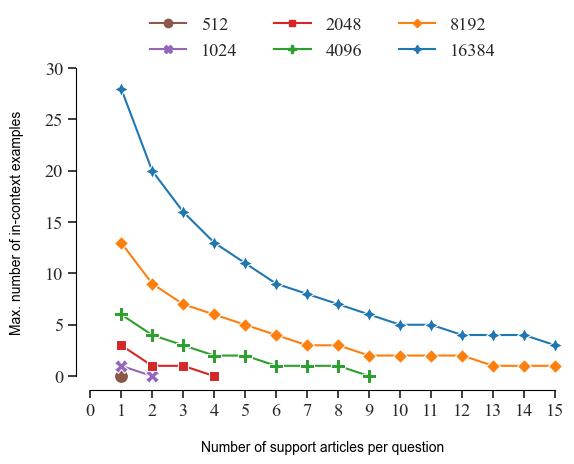

In [33]:
print("\n", "#", "-"*40, "#", "\n", "# TOKEN LENGTH DISTRIBUTION", "\n", "#", "-"*40, "#", sep="")
inst = """You are an expert jurist. You will be given a question along with several legal articles, which may contain both relevant and irrelevant information. 
Your task is to filter out the unnecessary details and use only the pertinent information from these articles to formulate a comprehensive yet straightforward 
response in very simple language. The response should be written in French and should cite the identifiers of the articles it refers to."""
inst_tokens = len(inst.split()) * 1.3
art_tokens = estimate_num_tokens(dfA, 'article')
quest_tokens = estimate_num_tokens(dfQ, 'question')
ans_tokens = estimate_num_tokens(dfQ, 'answer')
print(f"Instruction: {inst_tokens}\n\nArticle:\n{art_tokens}\n\nQuestion:\n{quest_tokens}\n\nAnswer:\n{ans_tokens}\n")

# print("\n", "#", "-"*40, "#", "\n", "# QUESTIONS WITH K REFERENCES", "\n", "#", "-"*40, "#", sep="")
# print("All train questions:", dfQ_train.shape[0])
# for k in range(1, 11):
#     print(f"Number of questions with at most {k} relevant articles: {dfQ_train[dfQ_train['article_ids'].apply(lambda x: len(x) <= k)].shape[0]}")

data = calculate_evidence_demonstrations_balance(
    instruction_len=inst_tokens, 
    question_len=quest_tokens['mean'], 
    provision_len=art_tokens['mean'], 
    answer_len=ans_tokens['mean'],
)
plot = create_evidence_demos_plot(data)
save_seaborn_figure_for_paper(
    plot=plot,
    filename="evidence_demos_balance",
    xlabel="Number of support articles per question", 
    ylabel="Max. number of in-context examples",
    xlim=(0, 15), xtick_step=1,
    ylim=(0, 30), ytick_step=5,
)

-> We have an average of 311 tokens per article referenced in the training set. Therefore, for a LLM context length of:
* 512 tokens: 1.6 articles
* 1024 tokens: 3.3 articles
* 2048 tokens: 6.6 articles

If we select an LLM with a context length of 2048 tokens, we should be able to give the model 5 articles. As a result, our retriever should really optimize for recall@5.

Knowing that, we should finetune our LLM with questions that have at most 5 relevant articles. This reduces our training set from 1673 to 1286 questions.